In [1]:
import openmc
import numpy as np

In [2]:
# to make the geometry, convert the serpent geometry then do the following:
# 1. delete cell 334 and 335
# 2. chainge remove material from cell 333 and make the fill universe 24
# 3. make the region of surface 948 the negative halfspace

# broken geometry universes: 7,13 2, 

In [3]:
# Create materials
mat = openmc.Materials.from_xml()
moder, hast, fuel = mat
# mat = openmc.Materials()
# ...

In [4]:
colormap = {mat[0]: 'purple',
           mat[1]: 'blue',
           mat[2]: 'yellow'}

In [5]:
def bound_zone_cells(cells_tuples, levels):
    cell_list = []
    for i, cells in enumerate(cells_tuples):
        lower_bound = levels[i]
        upper_bound = levels[i+1]
        for j, cell in enumerate(cells):
            cell.region = cell.region & +lower_bound & -upper_bound
            cell_list.append(cell)
    return cell_list

def shared_zone_geometry():
    elem_bound = openmc.rectangular_prism(5.08*2, 5.08*2) # Pin outer boundary

    gr_sq = openmc.rectangular_prism(4.953*2, 4.953*2) # Graphite square

    # params for main pin section for both I-A and II-A
    r_d = 0.66802
    l1 = 4.28498
    l2 = 4.53898
    l3 = 5.62102
    ul = openmc.ZCylinder(-l1, l2, r_d, name='corner_ul')
    br = openmc.ZCylinder(l1, -l2, r_d, name='corner_br')
    lb = openmc.ZCylinder(-l2, -l1, r_d, name='corner_lb')
    ru = openmc.ZCylinder(l2, l1, r_d, name='corner_ru')
    ul_t = openmc.ZCylinder(-l1, -l3, r_d, name='corner_ul_tip')
    br_t = openmc.ZCylinder(l1, l3, r_d, name='corner_br_tip')
    ru_t = openmc.ZCylinder(-l3, l1, r_d, name='corner_ru_tip')
    lb_t = openmc.ZCylinder(l3, -l1, r_d, name='corner_lb_tip')

    gr_sq_surfs = gr_sq.get_surfaces()
    gr_sq_keys = list(gr_sq_surfs.keys())
    min_x = gr_sq_surfs[gr_sq_keys[0]]
    max_x = gr_sq_surfs[gr_sq_keys[1]]
    min_y = gr_sq_surfs[gr_sq_keys[2]]
    max_y = gr_sq_surfs[gr_sq_keys[3]]

    gr_sq_pos = -min_x | +max_x | -min_y | +max_y
    gr_sq_neg = gr_sq

    gr_corners = elem_bound & (-ul | -br | -lb | -ru | 
                               -ul_t | -br_t | -ru_t | -lb_t)

    inter_elem_channel = (gr_sq_pos & elem_bound &
                         +ul & +br & +lb & +ru &
                         +ul_t & +ru_t & +ru_t & +lb_t)
    
    gr_round_4 = openmc.ZCylinder(r=2.2225, name='gr_round_4')

    
    return elem_bound, gr_corners, gr_sq_neg, inter_elem_channel, gr_round_4
                        

In [6]:
elem_bound, gr_corners, gr_sq_neg, inter_elem_channel, gr_round_4 = shared_zone_geometry()

def zoneIA():
    elem_levels = [0.0, 22.86, 419.10, 438.15, 445.135, 449.58]
    s1 = openmc.ZCylinder(r=4.953, name='ia_gr_round_1')
    s2 = openmc.ZCylinder(r=1.71069, name='ia_fuel_hole')
    
    h = 12.66
    theta = np.arctan(4.953 / h)
    r2 = (1 / np.cos(theta))**2 - 1
    s3 = openmc.ZCone(z0=h + elem_levels[3], r2=r2, name='cone_i')
    s4 = openmc.ZCylinder(r=2.2225, name='ia_gr_round_4')

    c1 = openmc.Cell(fill=fuel, region=(-s2), name='ia_fuel_inner_1')
    c2 = openmc.Cell(fill=moder, region=(+s2 & -s1), name='ia_moderator_1')
    c3 = openmc.Cell(fill=fuel, region=(+s1 & elem_bound), name='ia_fuel_outer_1')
    ia1 = (c1, c2, c3)
                         
    # I-A  main (lower 2)
    c4 = c1.clone(clone_materials=False)
    c4.name = 'ia_fuel_inner_main'
    c5 = openmc.Cell(fill=moder, region=(+s2 &
                                          gr_sq_neg |
                                          gr_corners), name='ia_moderator_main')
    c6 = openmc.Cell(fill=fuel, region=(inter_elem_channel), name='ia_fuel_outer_main')
    iam = (c4, c5, c6)
                         
    # I-A 2 (upper 1)
    c7 = c1.clone(clone_materials=False)
    c7.name = 'ia_fuel_inner_2'
    c8 = c2.clone(clone_materials=False)
    c8.name = 'ia_moderator_2'
    c9 = c3.clone(clone_materials=False)
    c9.name = 'ia_fuel_outer_2'
    ia2 = (c7, c8, c9)

    # I-A 3 (upper 2)
    c10 = c1.clone(clone_materials=False)
    c10.name = 'ia_fuel_inner_3'
    c11 = openmc.Cell(fill=moder, region=(+s2 & -s3), name='ia_moderator_3')
    c12 = openmc.Cell(fill=fuel, region=(+s3 & elem_bound), name='ia_fuel_outer_3')
    ia3 = (c10, c11, c12)                             
                         
    # I-A 4 (upper 3)
    c13 = openmc.Cell(fill=hast, region=(-s2), name='ia_hast')
    c14 = openmc.Cell(fill=moder, region=(+s2 & -gr_round_4), name='ia_moderator_4')
    c15 = openmc.Cell(fill=fuel, region=(+gr_round_4 & elem_bound), name='ia_fuel_outer_4')
    ia4 = (c13, c14, c15)
    
    elem_cells = [ia1, iam, ia2, ia3, ia4]
    ia = openmc.Universe()
    ia.add_cells(bound_zone_cells(elem_cells, elem_levels))
                 
    return ia

def zoneIIA():
    elem_levels = [0.0, 434.34, 436.88, 439.42, 441.96, 449.58]
    s1 = openmc.ZCylinder(r=3.302, name='iia_fuel_hole_main') # Hole with fuel salt - Fig 3.5, Roberton 1971 (3.27787 - p.47)
    s2 = openmc.ZCylinder(r=0.635, name='iia_fuel_hole_2')
    s3 = openmc.ZCylinder(r=3.65125, name='iia_gr_round_3')
    h = 6.5
    theta = np.arctan(3.65125 / h)
    r2 = (1 / np.cos(theta))**2 - 1
    s4 = openmc.ZCone(z0=h + elem_levels[3], r2=r2, name='cone_ii')

    # II-A main (lower 1)
    c1 = openmc.Cell(fill=fuel, region=(-s1), name='iia_fuel_inner_main')
    c2 = openmc.Cell(fill=moder, region=(+s1 & gr_sq_neg | gr_corners), name='iia_moderator_main')
    c3 = openmc.Cell(fill=fuel, region=(inter_elem_channel), name='iia_fuel_outer_main')
    c3.name = 'iia_fuel_outer_main'
    iiam = (c1, c2, c3)

    # II-A 2 (upper 1)
    c4 = openmc.Cell(fill=fuel, region=(-s2), name='iia_fuel_inner_2')
    c5 = openmc.Cell(fill=moder, region=(+s2 & gr_sq_neg | gr_corners), name='iia_moderator_2')
    c6 = c3.clone(clone_materials=False)
    c6.name = 'iia_fuel_outer_2'
    iia2 = (c4, c5, c6)

    # II-A 3 (upper 2)
    c7 = c4.clone(clone_materials=False)
    c7.name = 'iia_fuel_inner_3'
    c8 = openmc.Cell(fill=moder, region=(+s2 & -s3), name='iia_moderator_3')
    c9 = openmc.Cell(fill=fuel, region=(+s3 & elem_bound), name='iia_fuel_outer_3')
    iia3 = (c7, c8, c9)

    # II-A 4 (upper 3)  
    c10 = openmc.Cell(fill=moder, region=(-s4), name='iia_moderator_4')
    c11 = openmc.Cell(fill=fuel, region=(+s4 & elem_bound), name='iia_fuel_outer_4')
    iia4 = (c10, c11)

    # II-A 5 (upper 4)
    c12 = openmc.Cell(fill=moder, region=(-gr_round_4), name='iia_moderator_5')
    c13 = openmc.Cell(fill=fuel, region=(+gr_round_4 & elem_bound), name='iia_fuel_outer_5')
    iia5 = (c12, c13)
    
    elem_cells = [iiam, iia2, iia3, iia4, iia5]
    
    iia = openmc.Universe()
    iia.add_cells(bound_zone_cells(elem_cells, elem_levels))
    return iia

In [ ]:
iia = zoneIIA()

In [ ]:
iia.plot(width=(20,20),
        basis='xy',
        colors=colormap,
        origin=(0.,0.,200),
        color_by='material',
        pixels=(400,400))

In [ ]:
from copy import deepcopy
import numpy as np


pin_bound = openmc.rectangular_prism(5.08*2, 5.08*2) # Pin outer boundary

pin_gr_sq = openmc.rectangular_prism(4.953*2, 4.953*2) # Graphite square

# params for main pin section for both I-A and II-A
r_d = 0.66802
l1 = 4.28498
l2 = 4.53898
l3 = 5.62102
lu = openmc.ZCylinder(-l1, l2, r_d)
rb = openmc.ZCylinder(l1, -l2, r_d)
lb = openmc.ZCylinder(-l2, -l1, r_d)
ru = openmc.ZCylinder(l2, l1, r_d)
lu_adj = openmc.ZCylinder(-l1, -l3, r_d)
rb_adj = openmc.ZCylinder(l1, l3, r_d)
ru_adj = openmc.ZCylinder(-l3, l1, r_d)
lb_adj = openmc.ZCylinder(l3, -l1, r_d)

pin_gr_sq_surfs = pin_gr_sq.get_surfaces()
pin_gr_sq_keys = list(pin_gr_sq_surfs.keys())
pin_gr_sq_minx = pin_gr_sq_surfs[pin_gr_sq_keys[0]]
pin_gr_sq_maxx = pin_gr_sq_surfs[pin_gr_sq_keys[1]]
pin_gr_sq_miny = pin_gr_sq_surfs[pin_gr_sq_keys[2]]
pin_gr_sq_maxy = pin_gr_sq_surfs[pin_gr_sq_keys[3]]

pin_gr_sq_pos = -pin_gr_sq_minx | +pin_gr_sq_maxx | -pin_gr_sq_miny | +pin_gr_sq_maxy
pin_gr_sq_neg = pin_gr_sq

pin_corners = pin_bound & (-lu |
                           -rb |
                           -lb |
                           -ru |
                           -lu_adj |
                           -rb_adj |
                           -ru_adj |
                           -lb_adj)

In [14]:
# Zone I-A

### REWRITE STRATEGEY
# 1. make cells
# 2. translate their regions
# 3. bound the regions with the appropriate bounding planes


# I-A 1 (lower 1)
ia_gr_round_1 = openmc.ZCylinder(r=4.953)
ia_fuel_hole = openmc.ZCylinder(r=1.71069)
ia_fuel_inner_1 = openmc.Cell(fill=fuel, region=(-ia_fuel_hole))
ia_moderator_1 = openmc.Cell(fill=moder, region=(+ia_fuel_hole &
                                                 -ia_gr_round_1))
ia_fuel_outer_1 = openmc.Cell(fill=fuel, region=(+ia_gr_round_1 &
                                                 pin_bound))
ia1 = (ia_fuel_inner_1, ia_moderator_1, ia_fuel_outer_1)

# I-A  main (lower 2)
ia_fuel_inner_main = ia_fuel_inner_1.clone(clone_materials=False)
ia_moderator_main = openmc.Cell(fill=moder, region=(+ia_fuel_hole &
                                      pin_gr_sq_neg |
                                      pin_corners))
ia_fuel_outer_main = openmc.Cell(fill=fuel, region=(pin_gr_sq_pos &
                                     pin_bound &
                                     +lu &
                                     +rb &
                                     +lb &
                                     +ru &
                                     +lu_adj &
                                     +rb_adj &
                                     +ru_adj &
                                     +lb_adj))
iam = (ia_fuel_inner_main, ia_moderator_main, ia_fuel_outer_main)

# I-A 2 (upper 1)
ia_fuel_inner_2 = ia_fuel_inner_1.clone(clone_materials=False)
ia_moderator_2 = ia_moderator_1.clone(clone_materials=False)
ia_fuel_outer_2 = ia_fuel_outer_1.clone(clone_materials=False)
ia2 = (ia_fuel_inner_2, ia_moderator_2, ia_fuel_outer_2)
                              
# I-A 3 (upper 2)
h = 12.66
theta = np.arctan(4.953 / h)
r2 = (1 / np.cos(theta))**2 - 1
cone_i = openmc.ZCone(z0=h, r2=r2)
ia_fuel_inner_3 = ia_fuel_inner_1.clone(clone_materials=False)
ia_moderator_3 = openmc.Cell(fill=moder, region=(+ia_fuel_hole &
                                                 -cone_i))
ia_fuel_outer_3 = openmc.Cell(fill=fuel, region=(+cone_i & 
                                                 pin_bound))
ia3 = (ia_fuel_inner_3, ia_moderator_3, ia_fuel_outer_3)                             

# I-A and II-A 4 (upper 3)
ia_gr_round_4 = openmc.ZCylinder(r=2.2225)
ia_hast = openmc.Cell(fill=hast, region=(-ia_fuel_hole))
ia_moderator_4 = openmc.Cell(fill=moder, region=(+ia_fuel_hole &
                                                 -ia_gr_round_4))
ia_fuel_outer_4 = openmc.Cell(fill=fuel, region=(+ia_gr_round_4 &
                                                 pin_bound))
ia4 = (ia_hast, ia_moderator_4, ia_fuel_outer_4)


# II-A main (lower 1)
iia_fuel_hole_main = openmc.ZCylinder(r=3.302) # Hole with fuel salt - Fig 3.5, Roberton 1971 (3.27787 - p.47)
iia_fuel_inner_main = openmc.Cell(fill=fuel, region=(-iia_fuel_hole_main))
iia_moderator_main = openmc.Cell(fill=moder, region=(+iia_fuel_hole_main &
                                      pin_gr_sq_neg |
                                      pin_corners))
iia_fuel_outer_main = ia_fuel_outer_main.clone(clone_materials=False)
iiam = (iia_fuel_inner_main, iia_moderator_main, iia_fuel_outer_main)

# II-A 2 (upper 1)
iia_fuel_hole_2 = openmc.ZCylinder(r=0.635)
iia_fuel_inner_2 = openmc.Cell(fill=fuel, region=(-iia_fuel_hole_2))
iia_moderator_2 = openmc.Cell(fill=moder, region=(+iia_fuel_hole_2 &
                                      pin_gr_sq_neg |
                                      pin_corners))
iia_fuel_outer_2 = ia_fuel_outer_main.clone(clone_materials=False)
iia2 = (iia_fuel_inner_2, iia_moderator_2, iia_fuel_outer_2)

# II-A 3 (upper 2)
iia_gr_round_3 = openmc.ZCylinder(r=3.65125)
iia_fuel_inner_3 = iia_fuel_inner_2.clone(clone_materials=False)
iia_moderator_3 = openmc.Cell(fill=moder, region=(+iia_fuel_hole_2 &
                                                  -iia_gr_round_3))
iia_fuel_outer_3 = openmc.Cell(fill=fuel, region=(+iia_gr_round_3 &
                                                  pin_bound))
iia3 = (iia_fuel_inner_3, iia_moderator_3, iia_fuel_outer_3)

# II-A 4 (upper 3)
h = 6.5
theta = np.arctan(3.65125 / h)
r2 = (1 / np.cos(theta))**2 - 1
cone_ii = openmc.ZCone(z0=h, r2=r2, name='test_2_a')
iia_moderator_4 = openmc.Cell(fill=moder, region=(-cone_ii))
iia_fuel_outer_4 = openmc.Cell(fill=fuel, region=(+cone_ii &
                                                  pin_bound))
iia4 = (iia_moderator_4, iia_fuel_outer_4)

# II-A 5 (upper 4)
iia_moderator_5 = openmc.Cell(fill=moder, region=(-ia_gr_round_4), name='test_1_a')
iia_fuel_outer_5 = openmc.Cell(fill=fuel, region=(+ia_gr_round_4 &
                                                 pin_bound))
iia5 = (iia_moderator_5, iia_fuel_outer_5)


            # ia   iia
pin_cells = [(ia1, iiam),
             (iam, iia2),
             (ia2, iia3),
             (ia3, iia4),
             (ia4, iia5)]
pin_levels = [(0.0, 0.0),
              (22.86, 434.34),
              (419.10, 436.88),
              (438.15, 439.42),
              (445.135, 441.96),
              (449.58, 449.58)]
#bounding surfaces
level_bounds = []
for levels in pin_levels:
    ia_bound = openmc.ZPlane(z0=levels[0])
    iia_bound = openmc.ZPlane(z0=levels[1])
    level_bounds.append((ia_bound, iia_bound))
ia_cell_list = []
iia_cell_list = []

In [15]:
def append_cell(i, cell, level, lower_bound, upper_bound, translate=True):
    if translate:
        cell.region = cell.region.translate((0.0,0.0,level), inplace=True)
    cell.region = cell.region & +lower_bound & -upper_bound
    return cell
    
for i, cells in enumerate(pin_cells):
    ia_cells, iia_cells = cells
    levels = pin_levels[i]
    lower_bounds = level_bounds[i]
    upper_bounds = level_bounds[i+1]
    for j, ia_cell in enumerate(ia_cells):
        translate = True
        if i == 3 and j == 1:
            translate = False
        ia_cell_list.append(append_cell(i, ia_cell, 
                                        levels[0], 
                                        lower_bounds[0], 
                                        upper_bounds[0],
                                        translate=translate))
    for j, iia_cell in enumerate(iia_cells):
        translate = True
        if i == 3 and j == 1:
            translate = False
        iia_cell_list.append(append_cell(i, iia_cell, 
                                         levels[1], 
                                         lower_bounds[1], 
                                         upper_bounds[1],
                                         translate=translate))
        
ia = openmc.Universe(cells=ia_cell_list)
iia = openmc.Universe(cells=iia_cell_list)

In [10]:
iia = zoneIIA()

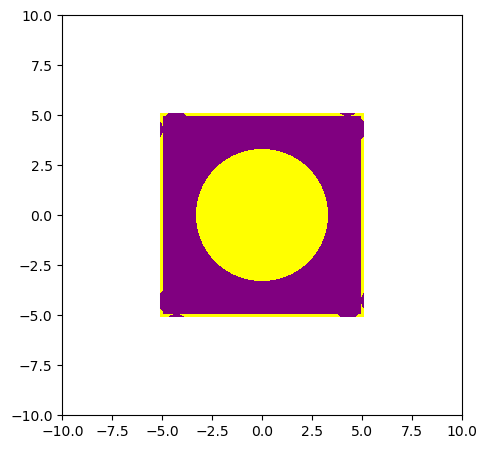

In [16]:
iia.plot(width=(20,20),
        basis='xy',
        colors=colormap,
        origin=(0.,0.,200),
        color_by='material',
        pixels=(400,400))

In [7]:
ia3[1].region.get_surfaces()

OrderedDict([(18,
              Surface
              	ID             =	18
              	Name           =	
              	Type           =	z-cylinder
              	Boundary       =	transmission
              	Coefficients   
              x0              =	0.0
              y0              =	0.0
              r               =	1.71069),
             (28,
              Surface
              	ID             =	28
              	Name           =	
              	Type           =	z-cone
              	Boundary       =	transmission
              	Coefficients   
              x0              =	0.0
              y0              =	0.0
              z0              =	12.66
              r2              =	0.1530626558253405)])

In [8]:
geo = openmc.Geometry()
geo.root_universe = ia
geo.export_to_xml()

In [9]:
geo = openmc.Geometry()
geo.root_universe = iia
geo.export_to_xml()

In [59]:
iam[1].region.get_surfaces()

OrderedDict([(491,
              Surface
              	ID             =	491
              	Name           =	
              	Type           =	z-cylinder
              	Boundary       =	transmission
              	Coefficients   
              x0              =	0.0
              y0              =	0.0
              r               =	1.71069),
             (415,
              Surface
              	ID             =	415
              	Name           =	minimum x
              	Type           =	x-plane
              	Boundary       =	transmission
              	Coefficients   
              x0              =	-4.953),
             (416,
              Surface
              	ID             =	416
              	Name           =	maximum x
              	Type           =	x-plane
              	Boundary       =	transmission
              	Coefficients   
              x0              =	4.953),
             (417,
              Surface
              	ID             =	417
              	Name          

In [ ]:
cone_i.cone

In [10]:
ia_plots = openmc.Plots()
iia_plots = openmc.Plots()

plot = openmc.Plot()
plot.origin=(0, 0, 10.0)
plot.width=(20, 20)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
ia_plots.append(plot)

plot = openmc.Plot()
plot.origin=(0, 0, 10.0)
plot.width=(20, 20)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
iia_plots.append(plot)

plot = openmc.Plot()
plot.origin=(0, 0, 23.0)
plot.width=(20, 20)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
ia_plots.append(plot)

plot = openmc.Plot()
plot.origin=(0, 0, 435)
plot.width=(20, 20)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
iia_plots.append(plot)

plot = openmc.Plot()
plot.origin=(0, 0, 420)
plot.width=(20, 20)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
ia_plots.append(plot)

plot = openmc.Plot()
plot.origin=(0, 0, 437)
plot.width=(20, 20)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
iia_plots.append(plot)

plot = openmc.Plot()
plot.origin=(0, 0, 439)
plot.width=(20, 20)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
ia_plots.append(plot)

plot = openmc.Plot()
plot.origin=(0, 0, 440)
plot.width=(20, 20)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
iia_plots.append(plot)

plot = openmc.Plot()
plot.origin=(0, 0, 448)
plot.width=(20, 20)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
ia_plots.append(plot)

plot = openmc.Plot()
plot.origin=(0, 0, 442)
plot.width=(20, 20)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
iia_plots.append(plot)

plot = openmc.Plot()
plot.origin=(0, 0, 450)
plot.width=(100, 100)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xz'
ia_plots.append(plot)

plot = openmc.Plot()
plot.origin=(0, 0, 450)
plot.width=(100, 100)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xz'
iia_plots.append(plot)

plot = openmc.Plot()
plot.origin=(0, 0, 50)
plot.width=(100, 100)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xz'
ia_plots.append(plot)

plot = openmc.Plot()
plot.origin=(0, 0, 50)
plot.width=(100, 100)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xz'
iia_plots.append(plot)

In [10]:
ia_plots.export_to_xml()

In [11]:
iia_plots.export_to_xml()

In [7]:
geo = openmc.Geometry([ia_fuel_outer_main])

In [8]:
geo.export_to_xml()

In [14]:
ia_fuel_outer_main.region.get_surfaces()

OrderedDict([(5,
              Surface
              	ID             =	5
              	Name           =	minimum x
              	Type           =	x-plane
              	Boundary       =	transmission
              	Coefficients   
              x0              =	-4.953),
             (6,
              Surface
              	ID             =	6
              	Name           =	maximum x
              	Type           =	x-plane
              	Boundary       =	transmission
              	Coefficients   
              x0              =	4.953),
             (7,
              Surface
              	ID             =	7
              	Name           =	minimum y
              	Type           =	y-plane
              	Boundary       =	transmission
              	Coefficients   
              y0              =	-4.953),
             (8,
              Surface
              	ID             =	8
              	Name           =	maximum y
              	Type           =	y-plane
              	Boundary       